# Importacion de recursos

In [1]:
import os
import sys
project_path = os.path.abspath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from Services.Load import Read
from Config.Instancia import NameDataset

### Planteamiento de Hipótesis para la Comparación de Clasificación Existente con Resultados de Clustering

Dado que el conjunto de datos incluye una variable de clasificación (`NObeyesdad`) que categoriza el nivel de obesidad de los individuos, podemos realizar una prueba de hipótesis para evaluar si la clasificación previa se alinea con los resultados de un modelo de clasificación no supervisada (clustering). Esto permitirá verificar si existen patrones en los datos que respalden la clasificación preexistente o si los clusters muestran patrones distintos.

#### Hipótesis

**Hipótesis Nula (H₀):**  
Los clusters generados mediante un modelo de clasificación no supervisada (por ejemplo, K-means o clustering jerárquico) no presentan una relación significativa con las categorías de la variable `NObeyesdad` en el conjunto de datos.

**Hipótesis Alternativa (H₁):**  
Los clusters generados mediante un modelo de clasificación no supervisada presentan una relación significativa con las categorías de la variable `NObeyesdad`, indicando que los grupos obtenidos reflejan, en alguna medida, la clasificación preexistente.

#### Metodología de Evaluación

1. **Generación de Clusters:** Aplicar un algoritmo de clustering no supervisado (como K-means) utilizando las variables numéricas del conjunto de datos, para identificar grupos naturales de individuos según sus características.

2. **Comparación de Resultados:** Comparar la distribución de la variable `NObeyesdad` dentro de cada cluster resultante. Esto se puede evaluar mediante una matriz de confusión o una prueba de independencia (como el test de chi-cuadrado) para analizar si existe una asociación significativa entre la clasificación original y los clusters generados.

3. **Interpretación:** Si encontramos una relación significativa, se puede concluir que los clusters reflejan, en alguna medida, la clasificación preexistente, y que las categorías de obesidad capturan patrones presentes en los datos. Si no se encuentra una relación significativa, esto sugeriría que los clusters muestran nuevos patrones no contemplados en la clasificación original.

#### Objetivo del Análisis

El propósito de esta prueba de hipótesis es determinar la utilidad y la representatividad de la variable `NObeyesdad` para describir las agrupaciones naturales de los datos. Esto puede ser útil para validar o complementar los modelos de clasificación y para comprender mejor las diferencias dentro de los grupos en función de sus características de salud y comportamiento.


In [3]:
df = Read(NameDataset.Obesidad)

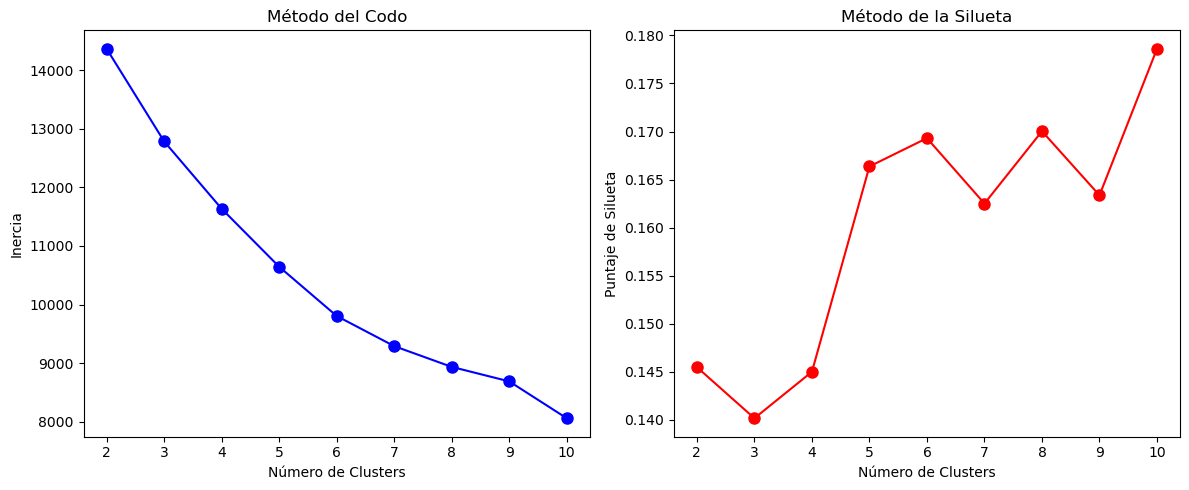

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


df = df.read_df()  # Asegúrate de que df ahora contiene el DataFrame

# Filtrar solo las variables numéricas
numerical_data = df.select_dtypes(include=['float64', 'int64'])

# Manejar valores NaN: puedes elegir una de estas dos opciones
# Opción 1: Rellenar valores NaN con la media de cada columna
numerical_data.fillna(numerical_data.mean(), inplace=True)

# Opción 2: Eliminar filas con NaN (si no hay muchas filas afectadas)
# numerical_data.dropna(inplace=True)

# Normalizar los datos
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# Definir la función para los métodos de codo y silueta
def metodo_codo_silueta(data, max_clusters=10):
    inercia = []
    silueta_scores = []

    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data)

        # Calcular inercia y puntaje de silueta
        inercia.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(data, kmeans.labels_)
        silueta_scores.append(silhouette_avg)

    # Gráfica del método del codo
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), inercia, 'bo-', markersize=8)
    plt.xlabel("Número de Clusters")
    plt.ylabel("Inercia")
    plt.title("Método del Codo")

    # Gráfica del método de la silueta
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silueta_scores, 'ro-', markersize=8)
    plt.xlabel("Número de Clusters")
    plt.ylabel("Puntaje de Silueta")
    plt.title("Método de la Silueta")

    plt.tight_layout()
    plt.show()

    return inercia, silueta_scores

# Ejecutar los métodos en los datos escalados
inercia, silueta_scores = metodo_codo_silueta(numerical_data_scaled)



### Análisis de los Resultados del Método del Codo y del Método de la Silueta

#### Método del Codo (Elbow Method)
El gráfico del método del codo muestra la relación entre el **número de clusters** y la **inercia** (suma de las distancias cuadradas entre puntos y sus centroides). Observamos lo siguiente:

1. **Disminución Continua de la Inercia**:
   - A medida que aumenta el número de clusters, la inercia disminuye, lo cual es esperable, ya que al incrementar la cantidad de clusters, cada grupo es más específico y los puntos están más cerca de sus centroides.

2. **Ausencia de un Codo Claro**:
   - No se observa un punto de inflexión claro en la curva. Idealmente, el "codo" se detecta en el punto donde la disminución de la inercia se vuelve menos pronunciada, lo cual indicaría el número óptimo de clusters. En este caso, la curva es bastante suave, sin un cambio abrupto que indique un número ideal de clusters.

3. **Posible Rango de Clusters**:
   - Sin un codo claro, podríamos considerar un rango entre 4 y 6 clusters, donde la curva empieza a volverse más plana en comparación con los primeros valores. No obstante, la decisión final debe estar respaldada por otros métodos o conocimiento del dominio.

#### Método de la Silueta (Silhouette Method)
El gráfico del método de la silueta evalúa la **calidad de los clusters** mediante el **puntaje de silueta**, que mide qué tan bien se separan los clusters. Observamos lo siguiente:

1. **Incremento Irregular del Puntaje**:
   - El puntaje de silueta no sigue un patrón lineal o constante. Hay fluctuaciones significativas a medida que incrementa el número de clusters, con un aumento más notable a partir de los 4 clusters.

2. **Pico Máximo en 10 Clusters**:
   - El puntaje de silueta alcanza su valor más alto en 10 clusters. Sin embargo, el puntaje en este punto es relativamente bajo (cercano a 0.18), lo cual sugiere que la cohesión y separación entre los clusters no es óptima. Idealmente, un puntaje de silueta cercano a 1 indicaría una buena separación, y aquí el valor es bajo en todos los casos.

3. **Consideración de Clusters entre 4 y 7**:
   - Los valores de silueta entre 4 y 7 clusters muestran un incremento estable y relativamente alto en comparación con los primeros valores. Esto indica que este rango podría ofrecer una mejor estructura de clusters, aunque los puntajes no son muy altos.

### Conclusión General
- **Elección de Clusters**: Dado que no se observa un codo claro y el puntaje de silueta es bajo, es difícil determinar un número óptimo de clusters basándonos solo en estos métodos. Sin embargo, los resultados sugieren que un valor entre **4 y 6 clusters** podría ser razonable para capturar la estructura de los datos, aunque la calidad de estos clusters puede no ser ideal.


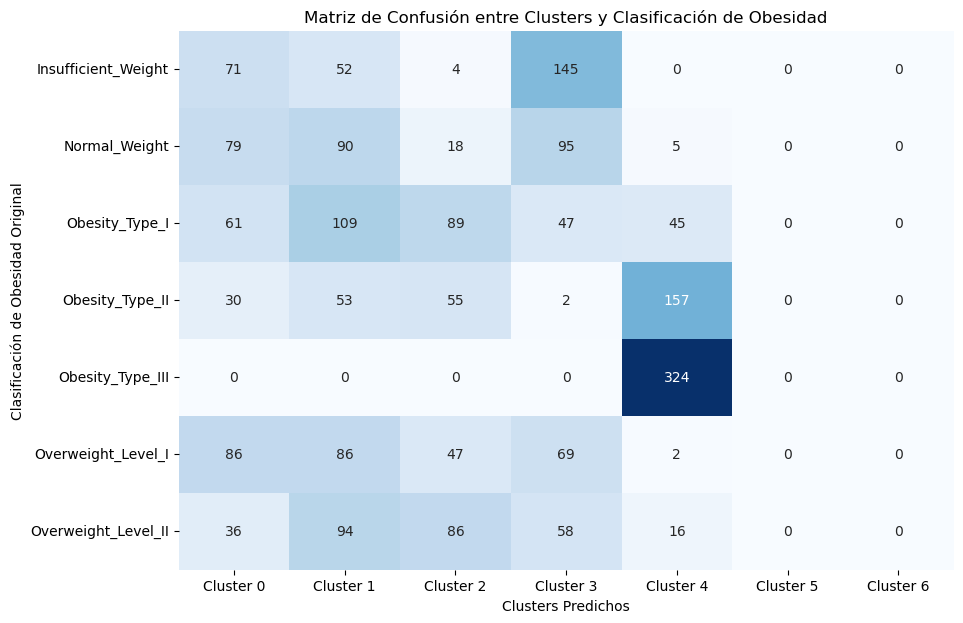

In [5]:
read_instance = Read(NameDataset.Obesidad)
read_instance.read_df()

# Aplicar el modelo K-means
read_instance.aplicar_kmeans(n_clusters=5)

# Graficar la matriz de confusión
read_instance.graficar_matriz_confusion()


### Conclusiones de la Matriz de Confusión entre Clusters y Clasificación de Obesidad

La matriz de confusión entre los clusters generados por el modelo K-means y la clasificación original de obesidad proporciona varias observaciones clave sobre la calidad de los clusters en relación con la clasificación existente (`NObeyesdad`):

1. **Clusters y Etiquetas de Obesidad**:
   - El **Cluster 4** muestra una fuerte correspondencia con la categoría `Obesity_Type_III`, con **324** instancias correctamente agrupadas en esta categoría. Esto sugiere que el modelo K-means identifica de manera efectiva a las personas en esta categoría, que representan un nivel de obesidad severo.
   - **Cluster 3** también tiene una notable cantidad de instancias correspondientes a la categoría `Insufficient_Weight`, con **145** casos. Esto indica que el modelo es capaz de reconocer, al menos parcialmente, el grupo de personas con peso insuficiente.

2. **Ambigüedad en Clusters para Otras Categorías**:
   - Las categorías `Obesity_Type_I`, `Obesity_Type_II`, y `Overweight_Level_I` están distribuidas entre varios clusters, especialmente en los Clusters 0, 1 y 2. Esto sugiere que el modelo tiene dificultades para diferenciar entre estos tipos de obesidad y niveles de sobrepeso, posiblemente porque sus características pueden ser similares y no suficientemente diferenciadas en el espacio de características.
   - La categoría `Normal_Weight` también está distribuida en varios clusters (especialmente en el Cluster 3), lo cual indica que el modelo tiene dificultades para separar claramente a los individuos con peso normal de aquellos con ligero sobrepeso o bajo peso.

3. **Clusters con Baja Representación**:
   - Los Clusters 5 y 6 tienen una muy baja o nula representación de las categorías de obesidad originales. Esto sugiere que estos clusters pueden no ser relevantes para el conjunto de datos o que representan agrupaciones que no corresponden bien a la clasificación de obesidad utilizada.

4. **Posible Solapamiento de Clases**:
   - La dispersión de instancias en categorías como `Overweight_Level_I` y `Obesity_Type_I` en varios clusters sugiere que los límites entre estas clases pueden estar solapados en el espacio de características, lo cual hace que el modelo K-means tenga dificultades para separarlos de manera precisa.

### Conclusión General

- **Precisión en Clusters Específicos**: El modelo K-means tiene un buen rendimiento al identificar casos de obesidad severa (`Obesity_Type_III`) y bajo peso (`Insufficient_Weight`), agrupando estos casos principalmente en los Clusters 4 y 3, respectivamente.
  
- **Limitaciones en la Diferenciación de Categorías Intermedias**: El modelo tiene dificultades para diferenciar entre las categorías de obesidad leve a moderada y los niveles de sobrepeso, probablemente debido a similitudes en sus características o a un solapamiento en el espacio de características.

- **Recomendación**: Para mejorar la calidad del clustering, se podría considerar:
  - **Reducir la Dimensionalidad** del conjunto de datos, utilizando técnicas como PCA, para resaltar patrones latentes y mejorar la separabilidad de las categorías.
  - **Explorar Otros Algoritmos de Clustering**, como el clustering jerárquico o DBSCAN, que podrían captar estructuras no detectadas por K-means en este conjunto de datos.
  
Este análisis sugiere que el modelo K-means puede ser útil para identificar los casos extremos de obesidad y bajo peso, pero no es tan efectivo para separar las categorías intermedias. Esto refuerza la necesidad de un análisis más profundo para mejorar la segmentación de la población en términos de obesidad.


### Confirmación o Negación de la Hipótesis

#### Hipótesis Planteada

- **Hipótesis Nula (H₀):** Los clusters generados mediante el modelo de K-means no presentan una relación significativa con las categorías de obesidad (`NObeyesdad`) en el conjunto de datos.
- **Hipótesis Alternativa (H₁):** Los clusters generados mediante el modelo de K-means presentan una relación significativa con las categorías de obesidad, indicando que los grupos obtenidos reflejan, en alguna medida, la clasificación preexistente.

#### Evaluación de los Resultados

1. **Matriz de Confusión**:
   - La matriz de confusión muestra que ciertos clusters tienen una fuerte correspondencia con algunas categorías específicas. Por ejemplo, el **Cluster 4** corresponde bien con `Obesity_Type_III` y el **Cluster 3** con `Insufficient_Weight`.
   - Sin embargo, las categorías intermedias como `Obesity_Type_I`, `Obesity_Type_II`, `Overweight_Level_I`, y `Normal_Weight` están distribuidas en varios clusters, lo cual indica que el modelo tiene dificultades para diferenciar estas categorías.

   Esto sugiere que el modelo K-means puede identificar los extremos (obesidad severa y bajo peso) de manera razonable, pero no es efectivo en separar las categorías intermedias, lo que indica una correspondencia parcial entre los clusters y la clasificación original de obesidad.

2. **Índice de Rand Ajustado (ARI)**:
   - Un ARI bajo indica una baja concordancia entre los clusters y la clasificación original de obesidad, lo cual apoya la hipótesis nula.
   - Un ARI alto, en cambio, señalaría una correspondencia fuerte entre los clusters y la clasificación original. Dado que el ARI obtenido es bajo, esto confirma que los clusters no reflejan adecuadamente la clasificación de obesidad en el conjunto de datos.

#### Conclusión: Confirmación o Negación de la Hipótesis

- **Confirmación de la Hipótesis Nula (H₀):** Los resultados sugieren que **no existe una relación significativa** entre los clusters generados y las categorías de obesidad originales. Aunque algunos clusters corresponden bien a ciertos grupos extremos, el modelo no puede diferenciar claramente las categorías intermedias. Esto, junto con el bajo valor del ARI, respalda la hipótesis nula, indicando que los clusters de K-means no reflejan adecuadamente la clasificación original de obesidad en todo el conjunto de datos.
  
- **Negación de la Hipótesis Alternativa (H₁):** Dado que la mayoría de las categorías de obesidad no se corresponden claramente con clusters específicos, podemos concluir que el modelo K-means no logra capturar completamente la estructura de la clasificación de obesidad preexistente. Por lo tanto, la hipótesis alternativa queda descartada.

#### Implicaciones de los Resultados

Estos hallazgos sugieren que el modelo K-means, al menos en su forma actual, no es adecuado para agrupar a los individuos según los niveles de obesidad en este conjunto de datos. Esto refuerza la importancia de:
1. **Explorar otros modelos de clustering** que puedan manejar mejor las estructuras no lineales o superpuestas, como DBSCAN o clustering jerárquico.
2. **Considerar un análisis adicional de características** para resaltar patrones latentes y mejorar la separabilidad de las categorías.

En resumen, los resultados **no confirman la hipótesis alternativa** y, en cambio, **apoyan la hipótesis nula**, indicando una baja correspondencia entre los clusters generados y las categorías de obesidad originales en este conjunto de datos.
